# CS4320 - Introduction to Machine Learning 

## Homework 5: Evaluation metrics

**Please type your name and A number here:**

In [1]:
Name = "Carson Fox"
assert Name != "", "Please enter your name in the above quotation marks, thanks!"

A_number = "A02251670"
assert (
    A_number != ""
), "Please enter your A-number in the above quotation marks, thanks!"

## Imports

In [48]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_recall_curve,
    precision_score,
    recall_score,
    RocCurveDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

rubric={points:12}

Consider the problem of predicting whether a patient has a disease or not. Below are confusion matrices of two machine learning models: Model A and Model B.

- Model A confusion matrix

In [3]:
cm_A = pd.DataFrame(
    [[3, 10], [1, 106]],
    columns=["Predicted disease", "Predicted no disease"],
    index=["Actual disease", "Actual no disease"],
)

cm_A

,Predicted disease,Predicted no disease
Actual disease,3,10
Actual no disease,1,106


- Model B confusion matrix

In [4]:
cm_B = pd.DataFrame(
    [[8, 5], [12, 95]],
    columns=["Predicted disease", "Predicted no disease"],
    index=["Actual disease", "Actual no disease"],
)

cm_B

,Predicted disease,Predicted no disease
Actual disease,8,5
Actual no disease,12,95


### 1.1 Positive vs. negative class 
rubric={points:1}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

A patient having the disease would be considered the positive class. This would be the class we're trying to identify; in the case the patient does not have the disease, there's nothing that needs to be done. Furthermore, this matches the way we typically discuss chemical tests that diagnose infection.

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [5]:
results_dict = {"A": {}, "B": {}}

In [6]:
total = cm_A.sum().sum()
results_dict["A"]["accuracy"] = (
    cm_A["Predicted disease"]["Actual disease"]
    + cm_A["Predicted no disease"]["Actual no disease"]
) / total
results_dict["B"]["accuracy"] = (
    cm_B["Predicted disease"]["Actual disease"]
    + cm_B["Predicted no disease"]["Actual no disease"]
) / total

In [7]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.908333,0.858333


### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

A, because it is $\approx$ 5% more accurate.

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without calling `scikit-learn` functions.

In [8]:
def precision(cm):
    true_positive = cm["Predicted disease"]["Actual disease"]
    pred_positive = cm["Predicted disease"].sum()
    return true_positive / pred_positive


def recall(cm):
    true_positive = cm["Predicted disease"]["Actual disease"]
    positive = (
        cm["Predicted disease"]["Actual disease"]
        + cm["Predicted no disease"]["Actual disease"]
    )
    return true_positive / positive


def f1(cm):
    p = precision(cm)
    r = recall(cm)
    return 2 * p * r / (p + r)


results_dict["A"]["precision"] = precision(cm_A)
results_dict["B"]["precision"] = precision(cm_B)
results_dict["A"]["recall"] = recall(cm_A)
results_dict["B"]["recall"] = recall(cm_B)
results_dict["A"]["f1"] = f1(cm_A)
results_dict["B"]["f1"] = f1(cm_B)

Show the dataframe with all results. 

In [9]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.908333,0.858333
precision,0.750000,0.400000
recall,0.230769,0.615385
f1,0.352941,0.484848


### 1.5 Discussion
rubric={points:2}

**Your tasks:**
1. Which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

Type your answer here:

1.

2.

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>
rubric={points:48}

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis. For now, we'll just treat it as a binary classification problem. 

In [10]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


### 2.1 Distribution of target values
rubric={points:2}

**Your tasks:**

Examine the distribution of target values in the train split.(Print out the count of each class) Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [11]:
train_df["churn"].value_counts()

False    1984
True      349
Name: churn, dtype: int64

There are about 2,000 negative samples, and only 350 positive. This is imbalanced, but not awful. We will probably see decent results without doing any extra preprocessing.

### 2.2 Column transformer 
rubric={points:12}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

You can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 


In each case, briefly explain your rationale with 1-2 sentences. You do not need an explanation for every feature, but for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

In [12]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [13]:
categorical = ["area code", "international plan", "voice mail plan"]
numeric = [
    "number vmail messages",
    "total day minutes",
    "total day calls",
    "total day charge",
    "total eve calls",
    "total eve charge",
    "total night minutes",
    "total night calls",
    "total night charge",
    "total intl minutes",
    "total intl calls",
    "total intl charge",
    "customer service calls",
]

ct = make_column_transformer(
    (OneHotEncoder(), categorical),
    (StandardScaler(), numeric),
)

Numerical columns were scaled by the standard scaler, while categorical columns were encoded in a one-hot form since none of them are ordinal. The phone number was dropped because it's probably irrelevant, but area code was kept because it gives geographic information. Since we're keeping the area code there's no reason to keep the state, since that's now redundant. We could probably drop the charge columns, if they're a multiple of the minutes columns. However, we have no guarantee that all customers are charged at the same rate, or that there aren't charges for using too many minutes. Thus those columns are all retained.

### 2.3 Visualizing the transformed data 
rubric={points:1}

Fit and transform your `ColumnTransformer` on your training set. Print the first 5 rows of the transformed data as a dataframe (not numpy array). See lecture for code that can get you the new column names after transforming. 

In [14]:
X_train_trans = pd.DataFrame(ct.fit_transform(X_train, y_train))
X_train_trans[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.587624,0.618769,-0.721211,0.618927,-1.156734,0.069926,1.088667,0.052115,1.089926,-1.645501,-0.200722,-1.644994,-0.415269
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,-0.587624,-1.293778,1.655252,-1.293517,-1.207278,-1.166291,-2.162302,-0.720990,-2.164029,0.227019,0.198158,0.222249,0.337507
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.900976,-0.609809,0.169963,-0.609654,0.157417,-2.211244,0.369287,-0.463288,0.369252,1.919489,-0.200722,1.916105,0.337507
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.587624,0.998345,-0.473663,0.998611,0.258506,-0.755774,1.597736,0.000574,1.596582,-0.097071,-0.599603,-0.097850,-0.415269
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,-0.587624,-0.994886,0.764078,-0.994731,-0.246937,1.196515,0.793839,0.206736,0.792921,0.407069,1.793679,0.408973,0.337507


### 2.4 Area code feature
rubric={points:1}

The original dataset had a feature called `area code`. Let's assume we encoded this feature with one-hot encoding.

1. The area codes were numbers to begin with. Why do we want to use one-hot encoding on this feature?

There is no ordering to area codes that is meaningful for this problem. If we don't use one-hot encoding, our classifier might learn an ordering that doesn't exist, and overfit to that ordering.

### 2.5 Dummy classifier
rubric={points:4}

**Your tasks:**

Create a `DummyClassifier`. Report the following scoring metrics via cross-validation: accuracy, precision, recall, f1-score. Briefly comment on your results, including any *warnings* the code produces (2 sentences max).

In [15]:
dummy = DummyClassifier()
model = make_pipeline(ct, dummy)
model.fit(X_train, y_train)
pd.DataFrame(cross_validate(model, X_train, y_train, scoring=['accuracy', 'precision', 'recall', 'f1']))

/home/fox/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fox/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fox/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fox/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.009300,0.008356,0.850107,0.0,0.0,0.0
1,0.008431,0.008230,0.850107,0.0,0.0,0.0
2,0.008495,0.007079,0.850107,0.0,0.0,0.0
3,0.009741,0.008047,0.851931,0.0,0.0,0.0
4,0.008779,0.007284,0.849785,0.0,0.0,0.0


Because some of the cross-validation splits contain no predicted positive samples, we're getting some divide by zero errors. A different strategy for the dummy classifier might solve this problem.

### 2.6 Logistic regression
rubric={points:4} 

**Your tasks:**

1. Create a `LogisticRegression`. 
2. Report the same metrics as in the previous part.

In [16]:
reg = LogisticRegression()
model = make_pipeline(ct, reg)
model.fit(X_train, y_train)
pd.DataFrame(cross_validate(model, X_train, y_train, scoring=['accuracy', 'precision', 'recall', 'f1']))

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.019305,0.006958,0.867238,0.653846,0.242857,0.354167
1,0.018483,0.006605,0.852248,0.520000,0.185714,0.273684
2,0.019126,0.007138,0.854390,0.535714,0.214286,0.306122
3,0.016394,0.006401,0.856223,0.529412,0.260870,0.349515
4,0.018136,0.006184,0.854077,0.541667,0.185714,0.276596


### 2.7 Logistic regression with `class_weight`
rubric={points:2}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences.

In [17]:
reg = LogisticRegression(class_weight='balanced')
model = make_pipeline(ct, reg)
model.fit(X_train, y_train)
pd.DataFrame(cross_validate(model, X_train, y_train, scoring=['accuracy', 'precision', 'recall', 'f1']))

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.023064,0.006775,0.775161,0.368421,0.700000,0.482759
1,0.015409,0.006309,0.768737,0.371622,0.785714,0.504587
2,0.016712,0.006876,0.773019,0.363636,0.685714,0.475248
3,0.016663,0.006374,0.746781,0.339869,0.753623,0.468468
4,0.019501,0.006485,0.733906,0.329114,0.742857,0.456140


### 2.8 Hyperparameter optimization
rubric={points:6}

Now let's tune the hyperparameters of our `LogisticRegression` using `GridSearchCV` to maximize cross-validation f1 score. 

**Your tasks:**

1. Jointly optimize `C` (choose some reasonable values) and `class_weight` (`None` vs. `'balanced'`) with `GridSearchCV` and `scoring="f1"`. 
2. What values of `C` and `class_weight` are chosen ? (Print out best "C" and best "class_weight")

In [26]:
reg = LogisticRegression()
pipe = make_pipeline(ct, reg)
model = GridSearchCV(pipe, {
    'logisticregression__C': [.01, .1, 1, 10, 100, 150, 200, 250],
    'logisticregression__class_weight': [None, 'balanced'],
}, scoring='f1')
model.fit(X_train, y_train)
model.best_params_

{'logisticregression__C': 200, 'logisticregression__class_weight': 'balanced'}

### 2.9 Test results
rubric={points:16}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Confusion matrix. 
    - Classification report. 
    - Precision-recall curve with average precision score.     
    - ROC curve with AUC. 

In [31]:
y_pred = model.predict(X_train)
confusion_matrix(y_train, y_pred)

array([[1522,  462],
       [  83,  266]])

In [34]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.948287,0.365385,0.766395,0.656836,0.861089
recall,0.767137,0.762178,0.766395,0.764657,0.766395
f1-score,0.848147,0.493965,0.766395,0.671056,0.795164
support,1984.000000,349.000000,0.766395,2333.000000,2333.000000


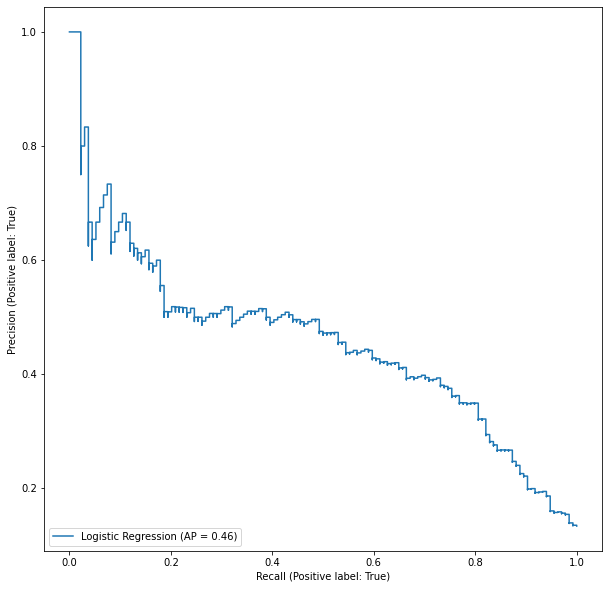

In [55]:
y_prob = model.predict_proba(X_train)[:, 1]
display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="Logistic Regression")
display.figure_.set_size_inches(10, 10)
display

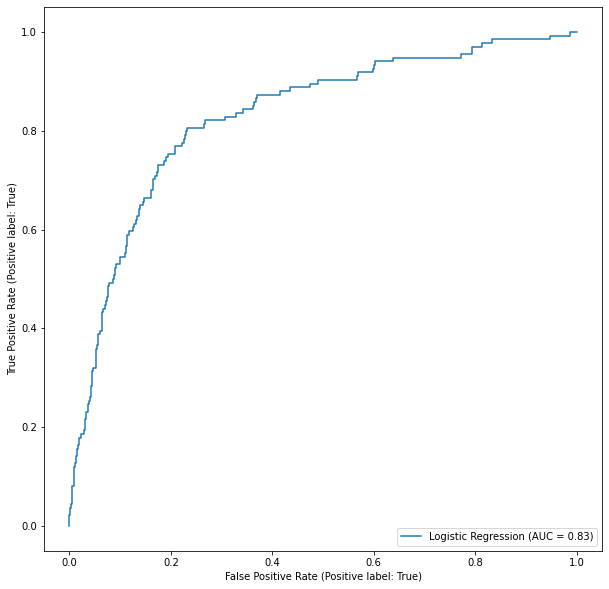

In [57]:
display = RocCurveDisplay.from_estimator(model, X_test, y_test, name="Logistic Regression")
display.figure_.set_size_inches(10, 10)
display

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


rubric={points=40}

For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [59]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:10}

**Your tasks:**

1. Split the data into train (80%) and test (20%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` in train and test splits. 

In [61]:
train_df, test_df = train_test_split(housing_df, test_size=.2, random_state=123)
train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
9950,4.5694,28.0,6.219512,1.030488,504.0,3.073171,38.38,-122.33,2.875
3547,5.6392,18.0,5.951644,1.034816,3010.0,2.911025,34.26,-118.60,2.715
4448,1.7292,47.0,3.628032,1.032345,1452.0,3.913747,34.07,-118.21,1.917
6984,4.6226,36.0,5.126238,0.985149,988.0,2.445545,33.96,-118.02,2.197
4432,2.4375,49.0,4.024390,0.942073,1405.0,4.283537,34.08,-118.20,1.140
...,...,...,...,...,...,...,...,...,...
7763,3.6389,36.0,5.584615,1.115385,490.0,3.769231,33.91,-118.10,1.676
15377,4.5391,14.0,6.016688,1.017972,2436.0,3.127086,33.37,-117.24,1.809
17730,5.6306,5.0,5.958393,1.031564,2435.0,3.493544,37.33,-121.76,2.862
15725,3.8750,44.0,4.739264,1.024540,561.0,1.720859,37.78,-122.44,4.125


In [62]:
scaler = StandardScaler()

In [64]:
target = 'MedHouseVal'
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

### 3.2 Baseline: DummyRegressor 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `DummyRegressor` with default scoring. 

In [73]:
pipe = make_pipeline(scaler, DummyRegressor())
pipe.fit(X_train, y_train)
pd.DataFrame(cross_validate(pipe, X_train, y_train))

,fit_time,score_time,test_score
0,0.006589,0.002372,-0.000023
1,0.005889,0.002335,-0.000576
2,0.004189,0.001468,-0.000061
3,0.003988,0.001451,-0.000015
4,0.004009,0.001498,-0.000058


### 3.3 Different regressors
rubric={points:8}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. Which model seems to be performing well with different metrics? 


In [74]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [ ]:
# Insert your code here:

Type your answer here:

### 3.4 Hyperparameter optimization 
rubric={points:8}

**Your tasks:**
1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose the metric of your choice for hyperparameter optimization. 

In [ ]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

In [ ]:
# Insert your code here:

### 3.5 Test results
rubric={points:6}

**Your tasks:**

1. Try the best model on the test set and use mape metric to evaluate your results.
2. Briefly comment on the results. (1 to 2 sentences) 

In [ ]:
# Insert your code here:

Type your answer here:

### 3.6 Model interpretation  
rubric={points:6}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Visualize coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. Use the `Ridge` model with best hyperparameters. Sort the coefficients in descending order. 
2. Increasing which feature values would result in higher housing price? 

In [ ]:
# Insert your code here:

Type your answer here:

## Submission instructions
<hr>

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Please keep your notebook clean and delete any throwaway code.